In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
import pandas as pd
data = pd.read_csv('employee.csv')

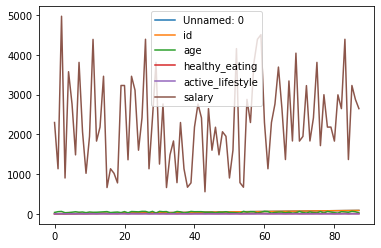

In [3]:
data.plot()

In [4]:
len(data)

88

In [7]:
del data['groups']

In [8]:
#Normalizing the data

data_n = data.copy()
data_n = (data - data.min())/(data.max() - data.min())
print(data_n)

    Unnamed: 0        id       age  healthy_eating  active_lifestyle    salary
0     0.000000  0.000000  0.391304           0.500          0.920741  0.394516
1     0.011494  0.011494  0.804348           0.250          0.936874  0.130977
2     0.022989  0.022989  0.934783           0.875          0.951283  1.000000
3     0.034483  0.034483  0.239130           0.250          0.963911  0.078405
4     0.045977  0.045977  0.347826           0.625          0.974708  0.683889
..         ...       ...       ...             ...               ...       ...
83    0.954023  0.954023  0.673913           1.000          0.465955  0.868797
84    0.965517  0.965517  0.456522           0.250          0.497345  0.183549
85    0.977011  0.977011  1.000000           0.750          0.528746  0.605484
86    0.988506  0.988506  0.760870           0.625          0.560033  0.526173
87    1.000000  1.000000  0.217391           0.625          0.591083  0.473601

[88 rows x 6 columns]


In [9]:
dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

    Unnamed: 0        id       age  healthy_eating  active_lifestyle  \
0     0.000000  0.000000  0.391304           0.500          0.920741   
1     0.011494  0.011494  0.804348           0.250          0.936874   
2     0.022989  0.022989  0.934783           0.875          0.951283   
3     0.034483  0.034483  0.239130           0.250          0.963911   
4     0.045977  0.045977  0.347826           0.625          0.974708   
..         ...       ...       ...             ...               ...   
83    0.954023  0.954023  0.673913           1.000          0.465955   
84    0.965517  0.965517  0.456522           0.250          0.497345   
85    0.977011  0.977011  1.000000           0.750          0.528746   
86    0.988506  0.988506  0.760870           0.625          0.560033   
87    1.000000  1.000000  0.217391           0.625          0.591083   

      salary  Unnamed: 0        id       age  healthy_eating  ...       age  \
0   0.394516         NaN       NaN       NaN            

In [10]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


15
16
45


In [11]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [12]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [13]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [14]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

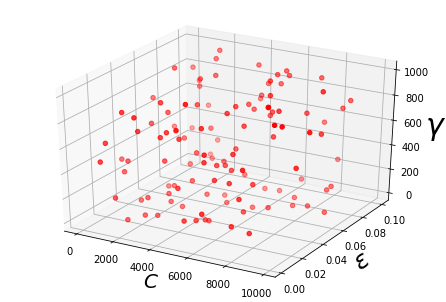





Best value iteration # 0 = 0.121372

Best value iteration # 1 = 0.121372

Best value iteration # 2 = 0.033306

Best value iteration # 3 = 0.007334

Best value iteration # 4 = 0.000417

Best value iteration # 5 = 0.000417

Best value iteration # 6 = 0.000417

Best value iteration # 7 = 0.000417

Best value iteration # 8 = 0.000417

Best value iteration # 9 = 0.000417

Best value iteration # 10 = 0.000417

Best value iteration # 11 = 0.000417

Best value iteration # 12 = 0.000417

Best value iteration # 13 = 0.000417

Best value iteration # 14 = 0.000417

Best value iteration # 15 = 0.000417

Best value iteration # 16 = 0.000417

Best value iteration # 17 = 0.000417

Best value iteration # 18 = 0.000417

Best value iteration # 19 = 0.000417

Best value iteration # 20 = 0.000417

Best value iteration # 21 = 0.000417

Best value iteration # 22 = 0.000417

Best value iteration # 23 = 0.000417

Best value iteration # 24 = 0.000417

Best value iteration # 25 = 0.000417

Best value iterati

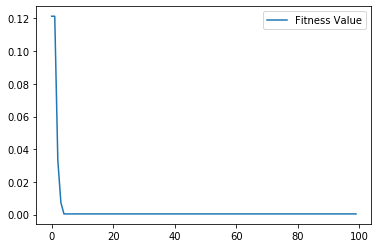

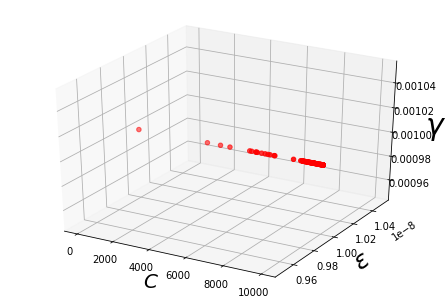





Predictions with the Population Best Value found:



C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


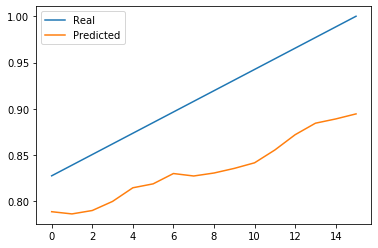





Mean Squared Error for the Test Set:	 0.006613




Predictions Average:	 0.834976




Predictions Median:	 0.830333






In [15]:
pso(120, 100, 3, 1)

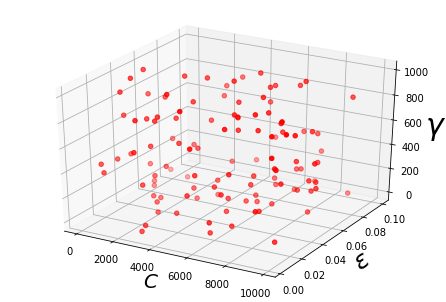





Best value iteration # 0 = 0.121372

Best value iteration # 1 = 0.121172

Best value iteration # 2 = 0.000417

Best value iteration # 3 = 0.000417

Best value iteration # 4 = 0.000417

Best value iteration # 5 = 0.000417

Best value iteration # 6 = 0.000417

Best value iteration # 7 = 0.000417

Best value iteration # 8 = 0.000417

Best value iteration # 9 = 0.000417

Best value iteration # 10 = 0.000417

Best value iteration # 11 = 0.000417

Best value iteration # 12 = 0.000417

Best value iteration # 13 = 0.000417

Best value iteration # 14 = 0.000417

Best value iteration # 15 = 0.000417

Best value iteration # 16 = 0.000417

Best value iteration # 17 = 0.000417

Best value iteration # 18 = 0.000417

Best value iteration # 19 = 0.000417

Best value iteration # 20 = 0.000417

Best value iteration # 21 = 0.000417

Best value iteration # 22 = 0.000417

Best value iteration # 23 = 0.000417

Best value iteration # 24 = 0.000417

Best value iteration # 25 = 0.000417

Best value iterati

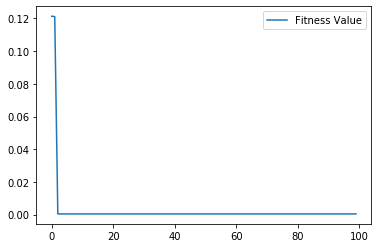

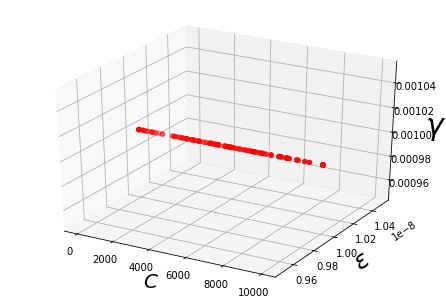





Predictions with the Population Best Value found:



C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


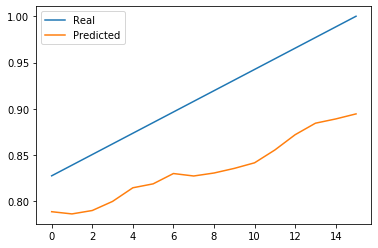





Mean Squared Error for the Test Set:	 0.006613




Predictions Average:	 0.834976




Predictions Median:	 0.830333






In [16]:
pso(120, 100, 3, 0.8)

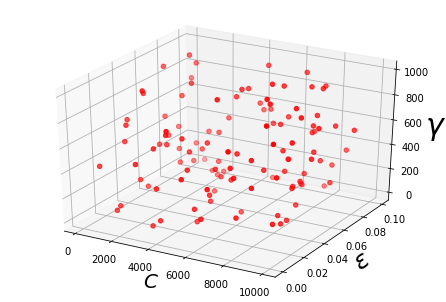





Best value iteration # 0 = 0.121372

Best value iteration # 1 = 0.001688

Best value iteration # 2 = 0.000417

Best value iteration # 3 = 0.000417

Best value iteration # 4 = 0.000417

Best value iteration # 5 = 0.000417

Best value iteration # 6 = 0.000417

Best value iteration # 7 = 0.000417

Best value iteration # 8 = 0.000417

Best value iteration # 9 = 0.000417

Best value iteration # 10 = 0.000417

Best value iteration # 11 = 0.000417

Best value iteration # 12 = 0.000417

Best value iteration # 13 = 0.000417

Best value iteration # 14 = 0.000417

Best value iteration # 15 = 0.000417

Best value iteration # 16 = 0.000417

Best value iteration # 17 = 0.000417

Best value iteration # 18 = 0.000417

Best value iteration # 19 = 0.000417

Best value iteration # 20 = 0.000417

Best value iteration # 21 = 0.000417

Best value iteration # 22 = 0.000417

Best value iteration # 23 = 0.000417

Best value iteration # 24 = 0.000417

Best value iteration # 25 = 0.000417

Best value iterati

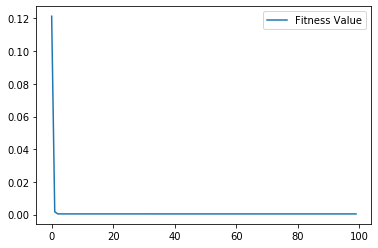

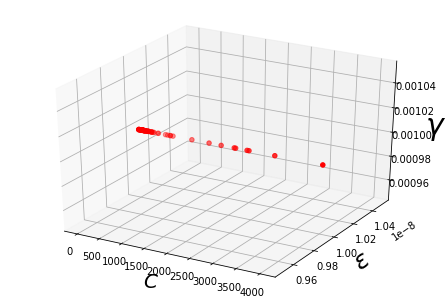





Predictions with the Population Best Value found:



C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


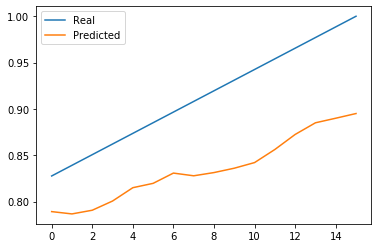





Mean Squared Error for the Test Set:	 0.006531




Predictions Average:	 0.835480




Predictions Median:	 0.830980






In [17]:
pso(120, 100, 3, 0.6)

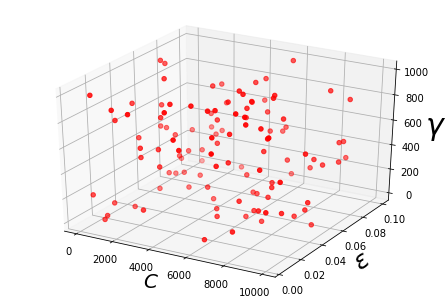





Best value iteration # 0 = 0.121372

Best value iteration # 1 = 0.121372

Best value iteration # 2 = 0.014868

Best value iteration # 3 = 0.000417

Best value iteration # 4 = 0.000417

Best value iteration # 5 = 0.000417

Best value iteration # 6 = 0.000417

Best value iteration # 7 = 0.000417

Best value iteration # 8 = 0.000417

Best value iteration # 9 = 0.000417

Best value iteration # 10 = 0.000417

Best value iteration # 11 = 0.000417

Best value iteration # 12 = 0.000417

Best value iteration # 13 = 0.000417

Best value iteration # 14 = 0.000417

Best value iteration # 15 = 0.000417

Best value iteration # 16 = 0.000417

Best value iteration # 17 = 0.000417

Best value iteration # 18 = 0.000417

Best value iteration # 19 = 0.000417

Best value iteration # 20 = 0.000417

Best value iteration # 21 = 0.000417

Best value iteration # 22 = 0.000417

Best value iteration # 23 = 0.000417

Best value iteration # 24 = 0.000417

Best value iteration # 25 = 0.000417

Best value iterati

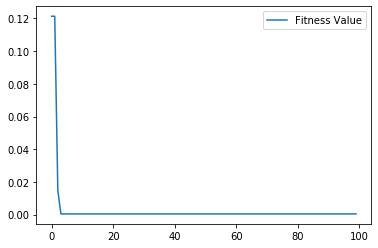

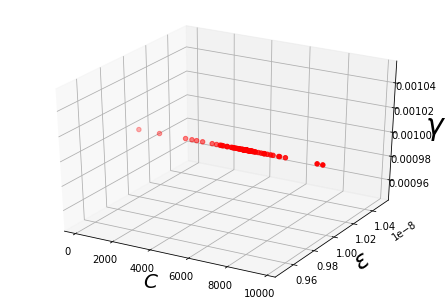





Predictions with the Population Best Value found:



C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


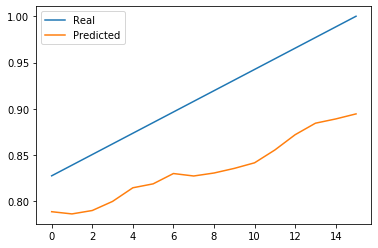





Mean Squared Error for the Test Set:	 0.006613




Predictions Average:	 0.834976




Predictions Median:	 0.830333






In [18]:
pso(120, 100, 3, 0.2)